In [1]:
from analyze import parse_bdd100k_labels

In [2]:
!ls

__pycache__                anchor_box_clustering.py
Analytics_Visualizer.ipynb bdd_parser.py
analyze.py


In [3]:
train_json = "../bdd100k_labels_images_train.json"
val_json = "../bdd100k_labels_images_val.json"

In [4]:
labels_path = "../bdd100k_labels_images_train.json"
df = parse_bdd100k_labels(labels_path)
print(df.head())
print(f"\nParsed {len(df)} annotations across {df['image_name'].nunique()} images.")

Parsing BDD100K annotations: 100%|█████████████| 69863/69863 [00:05<00:00, 13027.38it/s]


              image_name       category           x1          y1           x2  \
0  0000f77c-6257be58.jpg  traffic light  1125.902264  133.184488  1156.978645   
1  0000f77c-6257be58.jpg  traffic light  1156.978645  136.637417  1191.507960   
2  0000f77c-6257be58.jpg   traffic sign  1101.731743  211.122087  1170.790370   
3  0000f77c-6257be58.jpg   traffic sign     0.000000    0.246631   100.381647   
4  0000f77c-6257be58.jpg            car    45.240919  254.530367   357.805838   

           y2  occluded  truncated weather        scene timeofday  
0  210.875445     False      False   clear  city street   daytime  
1  210.875443     False      False   clear  city street   daytime  
2  233.566141     False      False   clear  city street   daytime  
3  122.825696     False       True   clear  city street   daytime  
4  487.906215     False      False   clear  city street   daytime  

Parsed 1286871 annotations across 69863 images.


Loading training data...


Parsing BDD100K annotations: 100%|█████████████| 69863/69863 [00:05<00:00, 13242.51it/s]


Loading validation data...


Parsing BDD100K annotations: 100%|█████████████| 10000/10000 [00:00<00:00, 26918.35it/s]


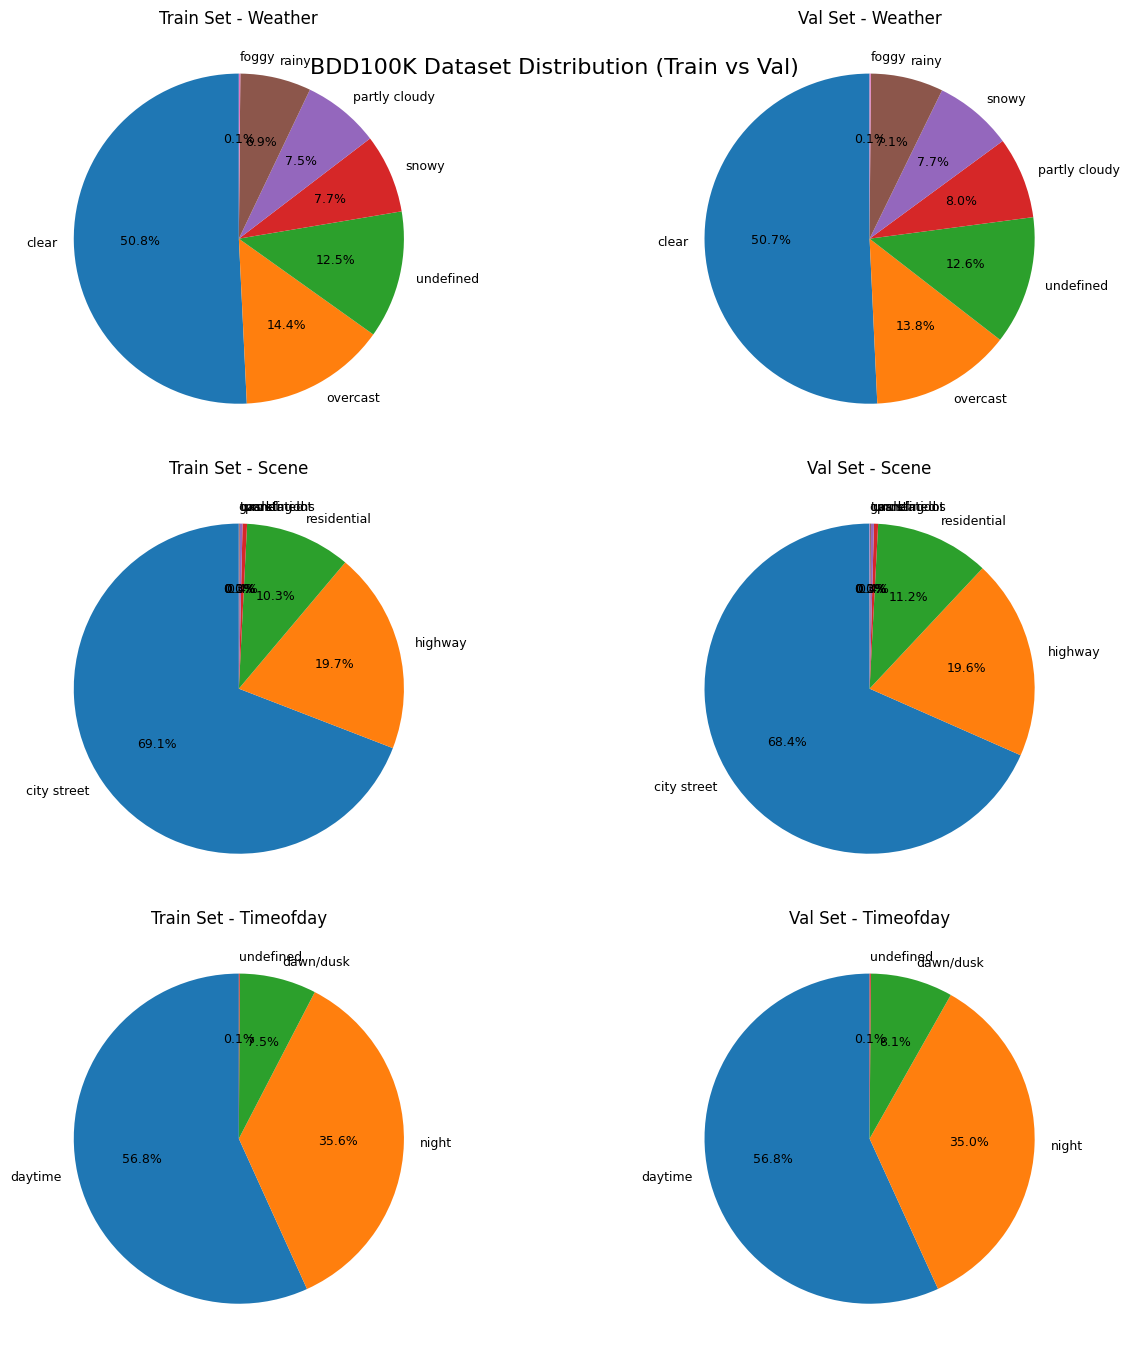

In [5]:
from analyze import plot_bdd_piecharts
train_json = "../bdd100k_labels_images_train.json"
val_json = "../bdd100k_labels_images_val.json"
plot_bdd_piecharts(train_json, val_json)

# Image Attribute Distribution

### Overview
1. Image attributes in the dataset include **weather**, **scene**, and **timeofday**.  
2. The distribution between the **validation** and **training** sets is reasonably similar.  
3. However, each attribute in the dataset shows an **overwhelming bias (>50%)** toward a single category.

---

## Conclusion

As seen from the dataset:

- **Weather:** Most images are captured in **clear weather** conditions.  
- **Scene:** Majority of images depict **city streets**.  
- **Time of Day:** Most images were taken during **daytime**.

---

## Solution

### Recommended Data Augmentations

1. **HSV Value (`hsv_v: 0.015`)**  
   - Minor adjustment to maintain **color consistency** across different camera sensors and lighting conditions.  

2. **HSV Saturation (`hsv_s: 0.7`)**  
   - Adjusts color vividness — making images more **vibrant** or **washed out**.  
   - Useful for handling **overcast vs. clear weather** conditions.  
   - High variation is suggested to mitigate **weather distribution imbalance**.  

3. **HSV Brightness (`hsv_v: 0.4`)**  
   - Alters image brightness (darker or brighter).  
   - Helps handle **day vs. night** distribution imbalance.

---



Loading training data...


Parsing BDD100K annotations: 100%|█████████████| 69863/69863 [00:05<00:00, 13628.97it/s]


Loading validation data...


Parsing BDD100K annotations: 100%|█████████████| 10000/10000 [00:00<00:00, 26499.84it/s]


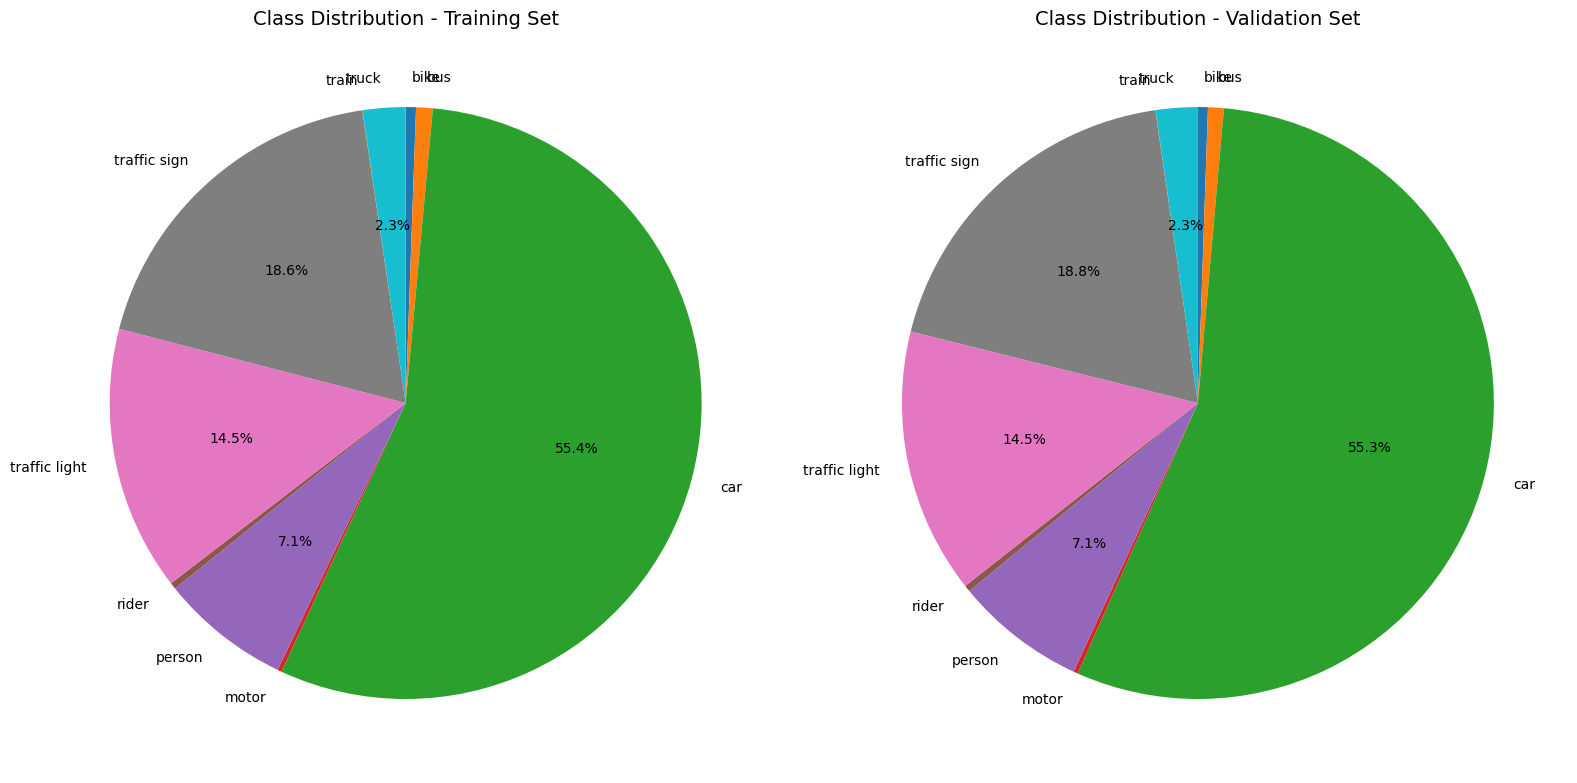

In [6]:
from analyze import plot_class_distribution_pie
train_counts, val_counts = plot_class_distribution_pie(train_json, val_json)

# Class Distribution Analysis

### Overview
1. The **class distribution** of the training and validation sets is **nearly identical**.  
2. However, the distribution is **heavily skewed** toward the **car** category, which represents **55.4%** of the dataset.  
3. The **train** category is **severely underrepresented**, accounting for less than **0.002%** of the data (only **136 annotations** in the training set).  
4. A few **incorrect annotations** have been observed in the **train** category.  
5. Some **annotation errors** have also been noted in the **rider** class.

---

## Solution

### Recommended Augmentation Strategies

1. **Mosaic Augmentation**  
   - Combines multiple images into one, effectively **upsampling rare classes** without explicit oversampling.  
   - Helps balance class frequency while maintaining spatial context.

2. **Varifocal Loss**  
   - Encourages the model to place **greater emphasis on rare classes** during training.  
   - Improves performance in **class-imbalanced datasets** by adjusting the focus dynamically based on confidence and sample rarity.

---


Loading training data...


Parsing BDD100K annotations: 100%|█████████████| 69863/69863 [00:04<00:00, 13974.55it/s]


Loading validation data...


Parsing BDD100K annotations: 100%|█████████████| 10000/10000 [00:00<00:00, 27946.13it/s]


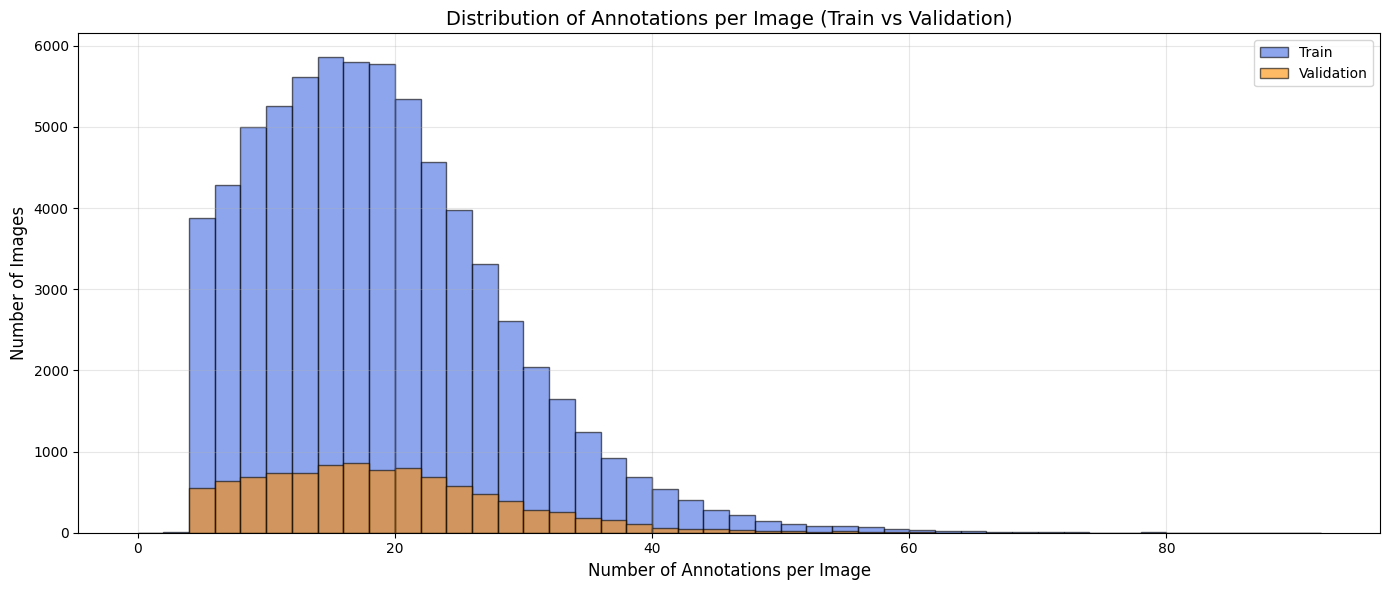


📊 Annotation Count Summary per Image:
|            |    mean |   median |   90th %ile |   max |   min |   count |
|:-----------|--------:|---------:|------------:|------:|------:|--------:|
| Train      | 18.4199 |       17 |          31 |    91 |     3 |   69863 |
| Validation | 18.5526 |       17 |          31 |    66 |     3 |   10000 |


In [7]:
from analyze import plot_annotations_per_image
train_counts, val_counts, stats_df = plot_annotations_per_image(train_json, val_json)

# Annotations per Image

### Overview
1. **Annotation density** is roughly consistent between the **training** and **validation** sets.  
2. The dataset exhibits a **moderate annotation density** overall.  
3. Some **crowded scenes** are present, with up to **91 objects per image**.  
4. There are **no empty images** in the dataset.  
5. **No sampling bias** observed — annotation consistency is maintained between the train and validation sets.

---

## Solution

1. **Anchor-Free Models**  
   - Better suited for **handling overlapping objects** compared to anchor-based models.  
   - Improve detection in **crowded or high-density scenes**.

2. **FPN / PAN Architectures (as in YOLOv8)**  
   - Utilize **Feature Pyramid Network (FPN)** and **Path Aggregation Network (PAN)** structures.  
   - These allow the model to **combine local details** and **broader contextual information**, enhancing detection performance across different scales.

---


In [8]:
from analyze import compare_mean_relative_bbox_size
compare_df = compare_mean_relative_bbox_size(train_json, val_json)

Loading training data...


Parsing BDD100K annotations: 100%|█████████████| 69863/69863 [00:04<00:00, 13990.47it/s]


Loading validation data...


Parsing BDD100K annotations: 100%|█████████████| 10000/10000 [00:00<00:00, 27717.94it/s]



📏 Mean Relative Size per Class (Train vs Validation):
----------------------------------------------------
 - bike           : Train=0.006429 | Val=0.005874
 - bus            : Train=0.038853 | Val=0.036540
 - car            : Train=0.010224 | Val=0.010188
 - motor          : Train=0.008229 | Val=0.008463
 - person         : Train=0.003196 | Val=0.003125
 - rider          : Train=0.006851 | Val=0.006479
 - traffic light  : Train=0.000551 | Val=0.000540
 - traffic sign   : Train=0.001301 | Val=0.001295
 - train          : Train=0.041911 | Val=0.031895
 - truck          : Train=0.030133 | Val=0.029756


# Mean Relative Size per Class

### Overview
1. There is a **huge variation in object scales** across classes.  
2. A significant portion of annotations fall under the **tiny to small** category.  
3. This indicates that the detector must effectively handle **multi-scale variations** during training and inference.

---

## Solution

1. **Multi-Stage Detection Head (YOLOv8 Architecture)**  
   - Enables simultaneous detection of **small** and **large** objects.  
   - Improves feature representation across multiple scales, enhancing detection accuracy for size-diverse classes.

2. **Higher Input Resolution**  
   - Helps **preserve features** of small and tiny objects that might otherwise be lost at lower resolutions.  
   - Beneficial when dealing with datasets dominated by **fine-grained, small-scale objects**.

---


Loading and parsing training data...


Parsing BDD100K annotations: 100%|█████████████| 69863/69863 [00:04<00:00, 14273.65it/s]


Loading and parsing validation data...


Parsing BDD100K annotations: 100%|█████████████| 10000/10000 [00:00<00:00, 28300.23it/s]



Aspect Ratio Summary per Class (Train):
----------------------------------
bike           : mean=0.96, median=0.85, var=0.27, 10–90%=0.49–1.58, n=7210
bus            : mean=1.43, median=1.17, var=0.74, 10–90%=0.74–2.45, n=11672
car            : mean=1.35, median=1.25, var=0.97, 10–90%=0.74–2.00, n=713211
motor          : mean=1.02, median=0.91, var=0.20, 10–90%=0.57–1.64, n=3002
person         : mean=0.46, median=0.41, var=0.11, 10–90%=0.28–0.67, n=91349
rider          : mean=0.58, median=0.54, var=0.10, 10–90%=0.38–0.81, n=4517
traffic light  : mean=0.71, median=0.61, var=0.22, 10–90%=0.37–1.16, n=186117
traffic sign   : mean=1.51, median=1.17, var=0.99, 10–90%=0.64–2.81, n=239686
train          : mean=3.73, median=1.66, var=23.77, 10–90%=0.67–9.01, n=136
truck          : mean=1.30, median=1.12, var=0.51, 10–90%=0.72–2.12, n=29971

Aspect Ratio Summary per Class (Validation):
----------------------------------
bike           : mean=0.96, median=0.86, var=0.22, 10–90%=0.49–1.55, n=100

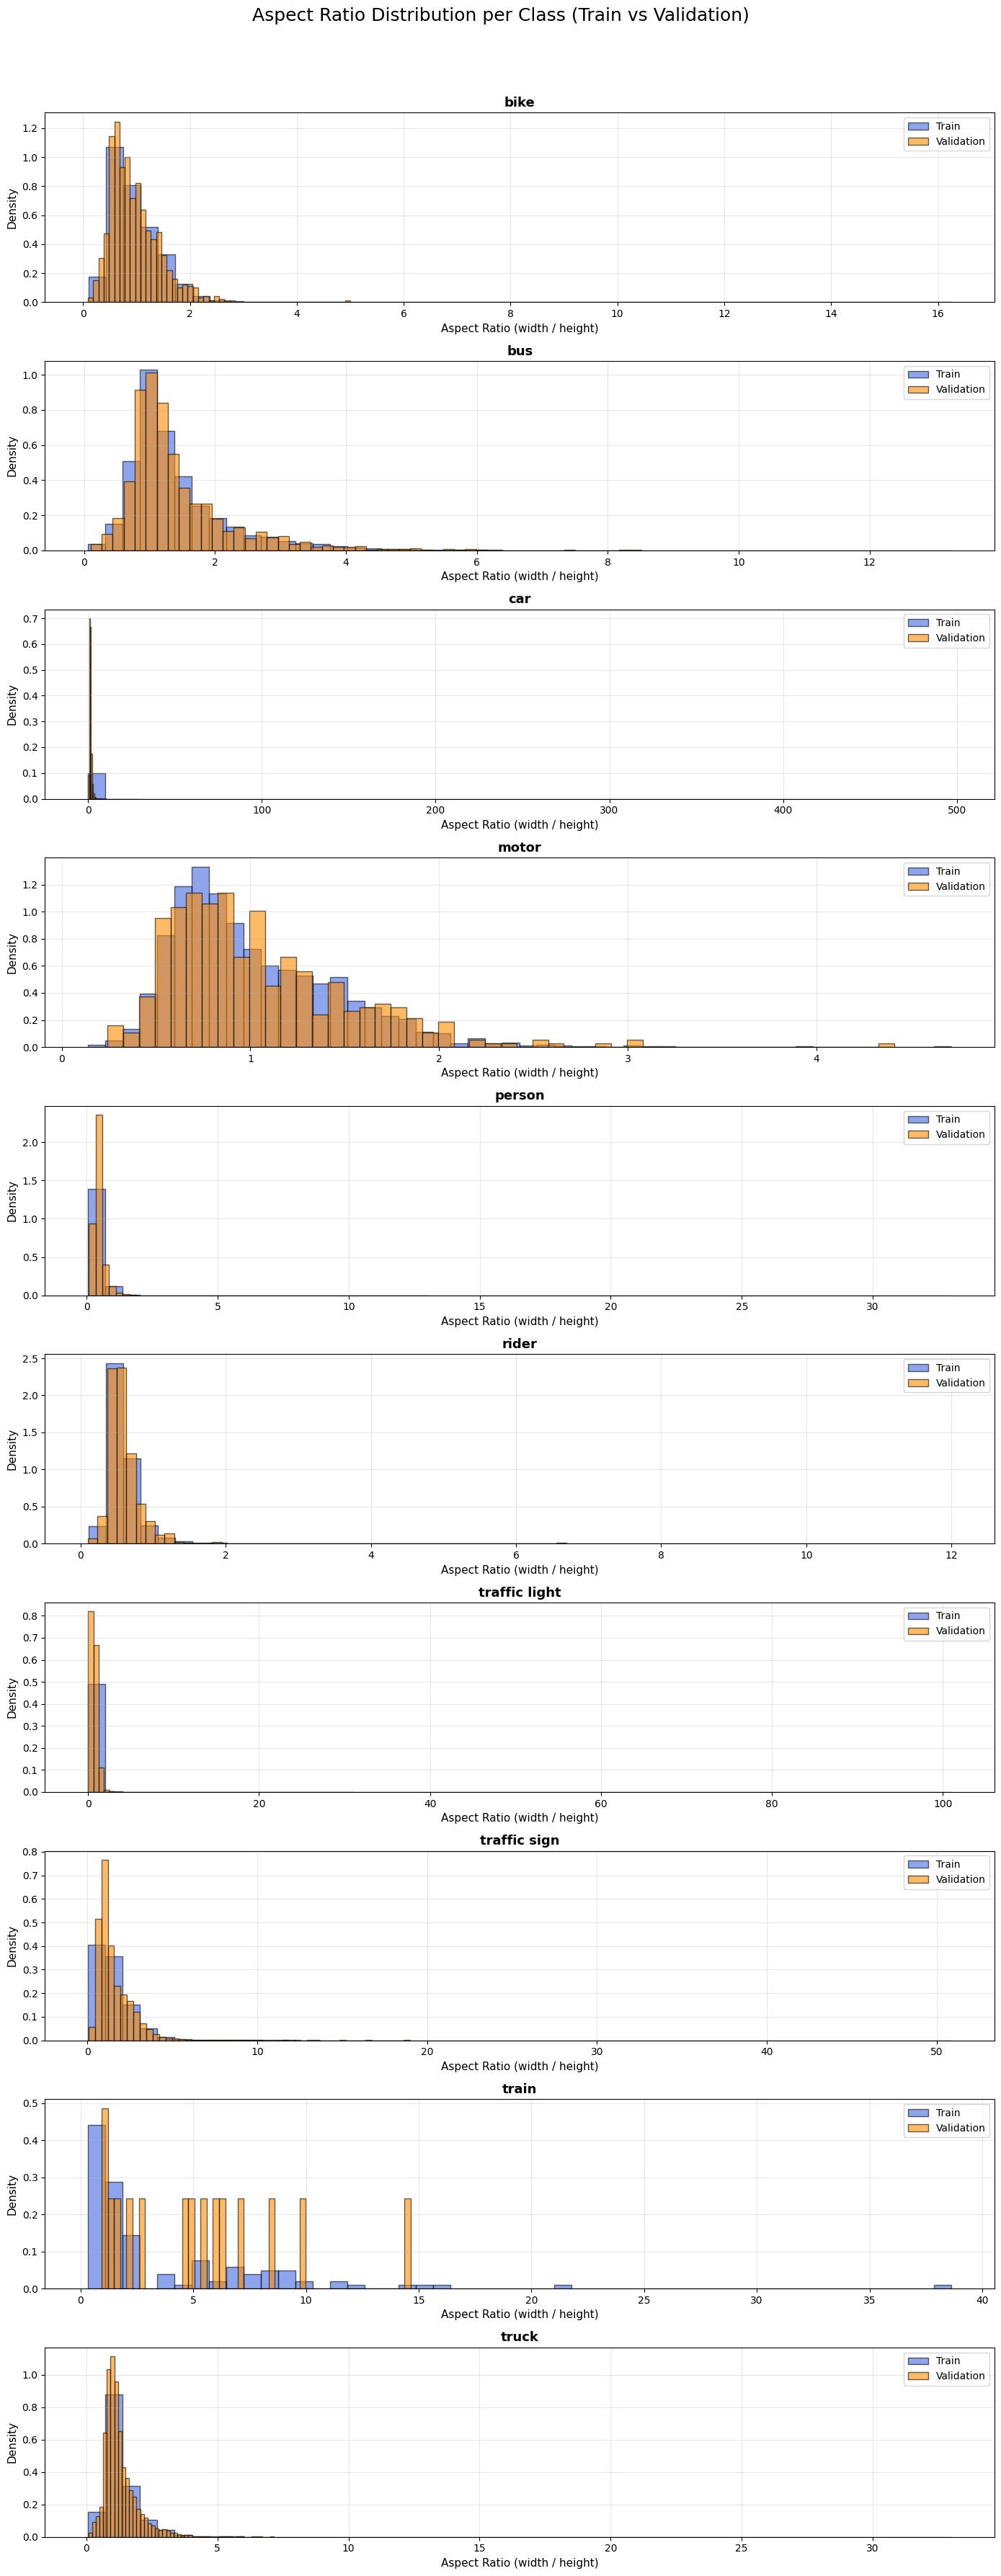

In [9]:
from analyze import plot_aspect_ratio_distribution
train_summary, val_summary = plot_aspect_ratio_distribution(train_json, val_json)

# Aspect Ratio per Class

### Overview
1. **Aspect ratio diversity** is high, with mean values ranging from **0.46 to 3.73**.  
2. There is also **significant variation within individual classes**.  
3. The **train** and **traffic sign** classes exhibit the **greatest variability** in aspect ratios.

---

## Solution

1. **Avoid Rotation Augmentation**  
   - Many classes display **consistent aspect ratio distributions**, so avoiding rotation helps the model **retain shape context** and improves generalization for shape-based recognition.  

2. **Anchor-Free Models (e.g., YOLOv8)**  
   - Better equipped to handle **high aspect ratio diversity** compared to anchor-based approaches.  
   - Improves bounding box adaptability across objects with irregular proportions.  

3. **Varifocal + DFL Loss**  
   - Enhances YOLOv8’s tolerance to **variable box shapes** and improves training stability.  
   - Enables the model to assign **dynamic confidence weighting** based on bounding box quality and aspect ratio variation.

---


Computing IoU overlaps across all images...


100%|███| 69863/69863 [00:23<00:00, 2960.41it/s]



📊 Mean IoU Overlaps per Class Pair (IoU ≥ 0.5):
                bike    bus    car  motor  person  rider  traffic light  \
bike           0.624  0.000  0.617  0.589   0.543  0.555          0.000   
bus            0.000  0.552  0.552  0.000   0.000  0.544          0.000   
car            0.617  0.552  0.583  0.579   0.561  0.564          0.714   
motor          0.589  0.000  0.579  0.616   0.545  0.572          0.000   
person         0.543  0.000  0.561  0.545   0.614  0.573          0.889   
rider          0.555  0.544  0.564  0.572   0.573  0.665          0.000   
traffic light  0.000  0.000  0.714  0.000   0.889  0.000          0.673   
traffic sign   0.000  0.000  0.580  0.000   0.000  0.688          0.658   
train          0.000  0.000  0.000  0.000   0.000  0.000          0.000   
truck          0.616  0.513  0.565  0.000   0.574  0.526          0.000   

               traffic sign  train  truck  
bike                  0.000    0.0  0.616  
bus                   0.000    0.0  0

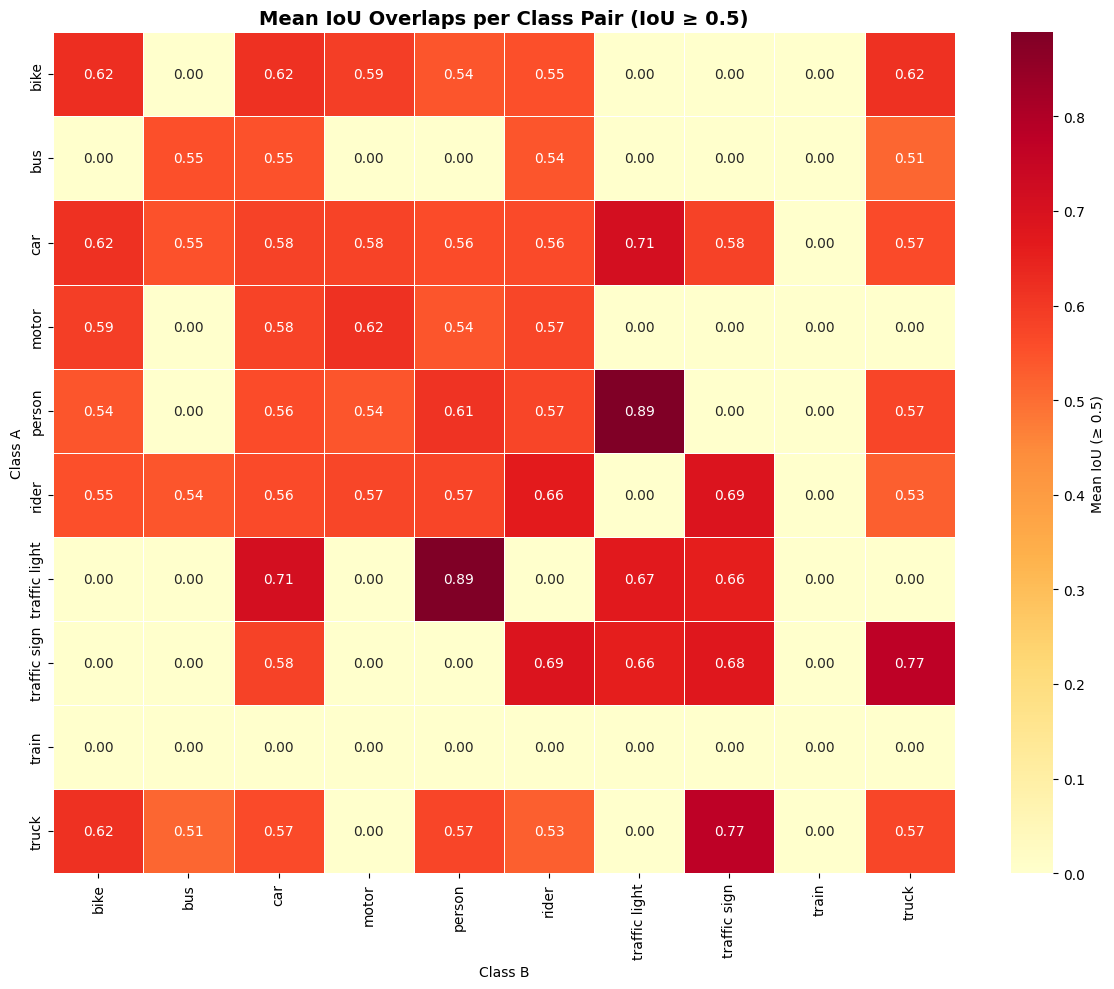

In [23]:
from analyze import compute_mean_iou_matrix, plot_iou_heatmap
iou_matrix, overlap_counts = compute_mean_iou_matrix(df, iou_thresh=0.5)

print("\n📊 Mean IoU Overlaps per Class Pair (IoU ≥ 0.5):")
print(iou_matrix.round(3))

plot_iou_heatmap(iou_matrix)

# Mean IoU Overlap per Class Pair

### Overview
1. The dataset shows **moderate overlap** between certain object classes.  
2. This can cause **true positives** to be mistakenly suppressed by standard **Non-Maximum Suppression (NMS)**.  
3. Proper handling of overlapping detections is crucial to preserve detection accuracy, especially in crowded scenes.

---

## Solution

1. **Soft-NMS**  
   - Use **Soft Non-Maximum Suppression** to prevent moderate overlaps between true positives from being wrongly discarded.  
   - Instead of completely removing overlapping boxes, Soft-NMS **reduces their confidence scores** based on IoU, allowing the detector to retain valid overlapping detections.

2. **IoU-Aware Loss Functions (e.g., Varifocal Loss)**  
   - Implementing **IoU-aware loss** during training helps the model better understand spatial overlap between bounding boxes.  
   - **Varifocal Loss** improves confidence calibration by aligning predicted scores with IoU values, enhancing performance in **densely overlapped** object regions.

---


Computing co-occurrence matrix across 69863 images...


100%|██████████████████████████████████████████| 69863/69863 [00:01<00:00, 36936.04it/s]



📊 Inter-class Co-occurrence Matrix (Train Set):
                bike    bus    car  motor  person  rider  traffic light  \
bike           0.062  0.012  0.061  0.006   0.046  0.035          0.048   
bus            0.012  0.129  0.128  0.006   0.060  0.010          0.084   
car            0.061  0.128  0.989  0.032   0.313  0.051          0.556   
motor          0.006  0.006  0.032  0.033   0.018  0.018          0.021   
person         0.046  0.060  0.313  0.018   0.316  0.033          0.235   
rider          0.035  0.010  0.051  0.018   0.033  0.051          0.039   
traffic light  0.048  0.084  0.556  0.021   0.235  0.039          0.562   
traffic sign   0.055  0.109  0.808  0.027   0.275  0.045          0.495   
train          0.000  0.000  0.001  0.000   0.001  0.000          0.001   
truck          0.021  0.045  0.269  0.008   0.108  0.017          0.156   

               traffic sign  train  truck  
bike                  0.055  0.000  0.021  
bus                   0.109  0.000  0

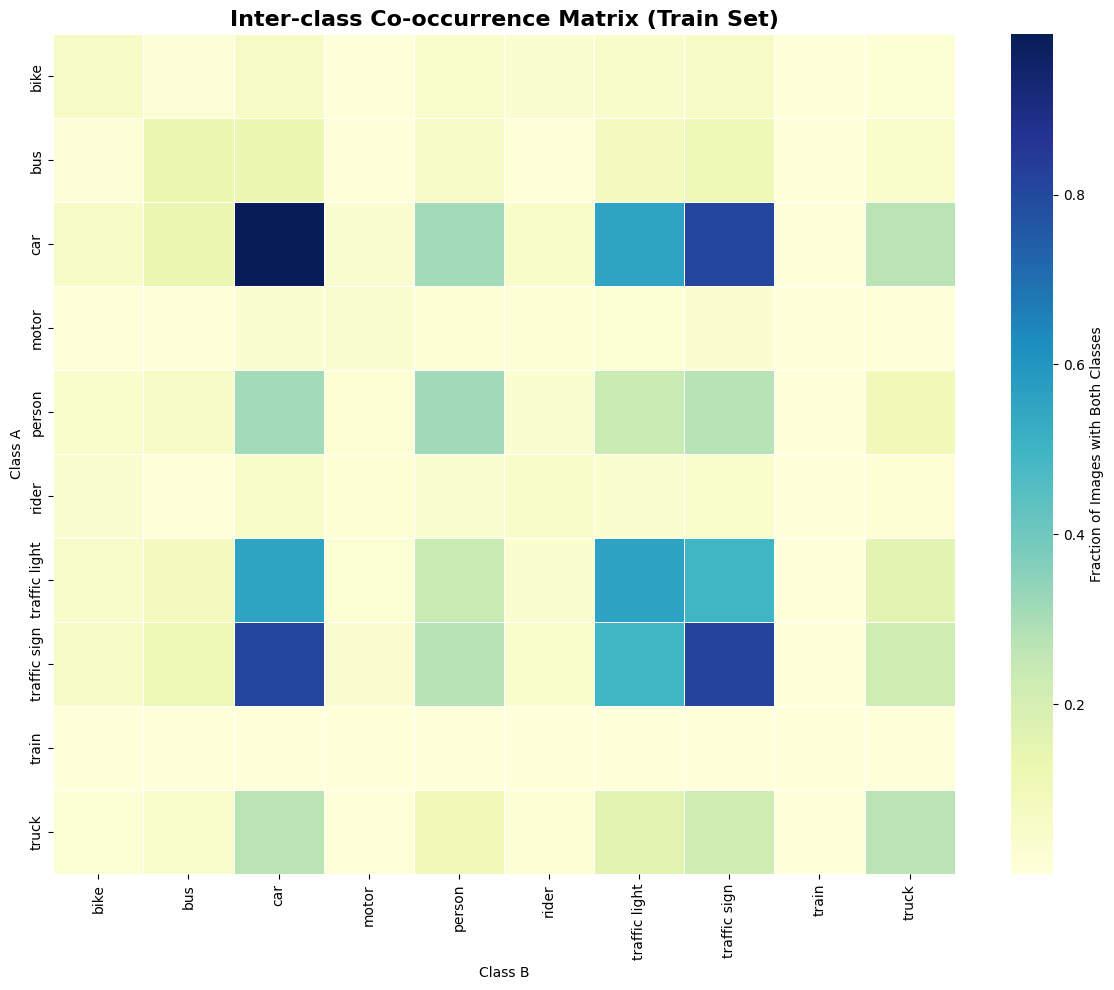

In [11]:
from analyze import compute_cooccurrence_matrix, summarize_cooccurrence, plot_cooccurrence_heatmap

co_matrix = compute_cooccurrence_matrix(df)

print("\n📊 Inter-class Co-occurrence Matrix (Train Set):")
print(co_matrix.round(3))

summarize_cooccurrence(co_matrix)
plot_cooccurrence_heatmap(co_matrix)